## Bibiliothèque

In [13]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1, resnet_v2
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

%matplotlib inline
seed = tf.random.set_seed(10)


## Utils

In [14]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [15]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [16]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits");
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================
Evaluation of Teacher model!
313/313 [==============================] - 9s 25ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Creating a data augmentation process

In [17]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building a preprocessing routine

In [18]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Resnet8 Student model 

In [19]:
print("============== Building Student Network Resnet8 ! =============")

student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

student = tf.keras.Sequential([
    preprocessing,
    student,   
])



print("")

============== Building Student Network Resnet8 ! =============



## Building callbacks

In [20]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

lr_reduce2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Scratch Training

In [21]:
student_scratch = resnet_v2(input_shape=(32, 32, 3), depth= 8)

student_scratch = tf.keras.Sequential([
    preprocessing,
    student_scratch,   
])

In [22]:
BATCH_SIZE = 32
EPOCHS = 100
lr = 0.1

NAME = f"Resnet8_scratch_with_callbacks"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs3/{NAME}", 
                                                 histogram_freq = 1)


student_scratch.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        )

    # Train and evaluate on data.
hist = student_scratch.fit(x_train, y_train, 
      batch_size = BATCH_SIZE,
      epochs=EPOCHS,
      steps_per_epoch = len(x_train)/BATCH_SIZE,
      validation_data =(x_test, y_test),
      workers =40,
      use_multiprocessing= True,
      callbacks = [lr_reduce2, tensorboard],
      )


student_scratch.evaluate(x_test, y_test)

print("")

print("End !")

Epoch 1/100
1562/1562 [==============================] - 59s 36ms/step - loss: 1.5199 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.5419 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 58s 37ms/step - loss: 1.1588 - sparse_categorical_accuracy: 0.6314 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.5921 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 53s 34ms/step - loss: 1.0441 - sparse_categorical_accuracy: 0.6848 - val_loss: 1.3826 - val_sparse_categorical_accuracy: 0.5754 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.9779 - sparse_categorical_accuracy: 0.7180 - val_loss: 1.9139 - val_sparse_categorical_accuracy: 0.5068 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 54s 35ms/step - loss: 0.9482 - sparse_categorical_accuracy: 0.7362 - val_loss: 1.5213 - val_sparse_categorical_accuracy: 0.5719 - lr: 0.1000
Epoch 6/10

1562/1562 [==============================] - 56s 36ms/step - loss: 0.4985 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.6461 - val_sparse_categorical_accuracy: 0.8448 - lr: 0.0100
Epoch 42/100
1562/1562 [==============================] - 54s 34ms/step - loss: 0.4745 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.8477 - lr: 0.0100
Epoch 43/100
1562/1562 [==============================] - 51s 33ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.9064 - val_loss: 0.6055 - val_sparse_categorical_accuracy: 0.8544 - lr: 0.0100
Epoch 44/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.4403 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.6159 - val_sparse_categorical_accuracy: 0.8508 - lr: 0.0100
Epoch 45/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.4242 - sparse_categorical_accuracy: 0.9128 - val_loss: 0.5950 - val_sparse_categorical_accuracy: 0.8510 - lr: 0.0100
Epoch 46/100
1562/

1562/1562 [==============================] - 53s 34ms/step - loss: 0.2273 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.8604 - lr: 1.0000e-04
Epoch 80/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2265 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.8600 - lr: 1.0000e-05
Epoch 81/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2273 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.8595 - lr: 1.0000e-05
Epoch 82/100
1562/1562 [==============================] - 54s 34ms/step - loss: 0.2262 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.5478 - val_sparse_categorical_accuracy: 0.8603 - lr: 1.0000e-05
Epoch 83/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.2271 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.5482 - val_sparse_categorical_accuracy: 0.8598 - lr: 1.0000e-0

## Knowledge distillation

In [23]:
BATCH_SIZE = 32
EPOCHS = 100
T = [5, 10, 15, 20, 25, 30, 35, 40, 100]
lr = 0.1

Epoch 1/100
1562/1562 [==============================] - 82s 50ms/step - sparse_categorical_accuracy: 0.4575 - student_loss: 2.0909 - Dist_loss: 1.1138 - loss: 1.2115 - val_sparse_categorical_accuracy: 0.5289 - val_student_loss: 2.4468 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6258 - student_loss: 1.7344 - Dist_loss: 0.7616 - loss: 0.8589 - val_sparse_categorical_accuracy: 0.6263 - val_student_loss: 2.5424 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.6854 - student_loss: 1.5066 - Dist_loss: 0.6321 - loss: 0.7195 - val_sparse_categorical_accuracy: 0.6614 - val_student_loss: 2.3868 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.7214 - student_loss: 1.3592 - Dist_loss: 0.5548 - loss: 0.6353 - val_sparse_categorical_accuracy: 0.6094 - val_student_loss: 2.4297 - lr: 0.1000
Epoc

Epoch 32/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9135 - student_loss: 0.3474 - Dist_loss: 0.1956 - loss: 0.2108 - val_sparse_categorical_accuracy: 0.8488 - val_student_loss: 1.3357 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9139 - student_loss: 0.3496 - Dist_loss: 0.1964 - loss: 0.2117 - val_sparse_categorical_accuracy: 0.8486 - val_student_loss: 1.3319 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9155 - student_loss: 0.3451 - Dist_loss: 0.1950 - loss: 0.2100 - val_sparse_categorical_accuracy: 0.8493 - val_student_loss: 1.3290 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9128 - student_loss: 0.3474 - Dist_loss: 0.1942 - loss: 0.2095 - val_sparse_categorical_accuracy: 0.8496 - val_student_loss: 1.3427 -

Epoch 62/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9137 - student_loss: 0.3460 - Dist_loss: 0.1938 - loss: 0.2090 - val_sparse_categorical_accuracy: 0.8494 - val_student_loss: 1.3287 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9141 - student_loss: 0.3469 - Dist_loss: 0.1947 - loss: 0.2099 - val_sparse_categorical_accuracy: 0.8489 - val_student_loss: 1.3279 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9148 - student_loss: 0.3438 - Dist_loss: 0.1941 - loss: 0.2091 - val_sparse_categorical_accuracy: 0.8497 - val_student_loss: 1.3287 - lr: 1.0000e-06
Epoch 65/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9148 - student_loss: 0.3415 - Dist_loss: 0.1933 - loss: 0.2081 - val_sparse_categorical_accuracy: 0.8490 - val_student_loss: 1.3280 -

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9161 - student_loss: 0.3374 - Dist_loss: 0.1926 - loss: 0.2071 - val_sparse_categorical_accuracy: 0.8488 - val_student_loss: 1.3197 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9153 - student_loss: 0.3447 - Dist_loss: 0.1935 - loss: 0.2086 - val_sparse_categorical_accuracy: 0.8490 - val_student_loss: 1.3329 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9156 - student_loss: 0.3421 - Dist_loss: 0.1932 - loss: 0.2081 - val_sparse_categorical_accuracy: 0.8487 - val_student_loss: 1.3134 - lr: 1.0000e-06
Epoch 97/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9152 - student_loss: 0.3435 - Dist_loss: 0.1943 - loss: 0.2092 - val_sparse_categorical_accuracy: 0.8495 - val_student_loss: 1.3279 - lr: 1.0000e-

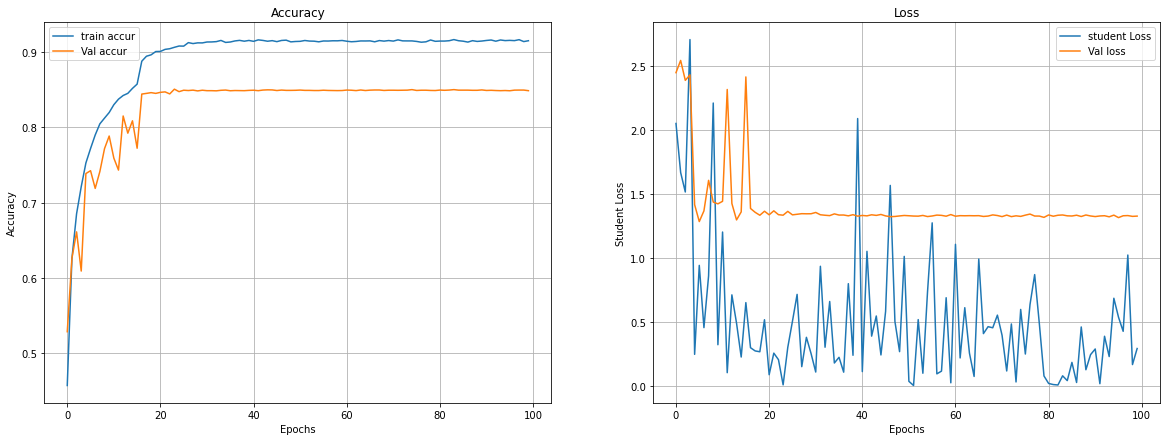

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 83s 51ms/step - sparse_categorical_accuracy: 0.4559 - student_loss: 1.8770 - Dist_loss: 0.5751 - loss: 0.7053 - val_sparse_categorical_accuracy: 0.4672 - val_student_loss: 2.6154 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6171 - student_loss: 1.5897 - Dist_loss: 0.4005 - loss: 0.5194 - val_sparse_categorical_accuracy: 0.6279 - val_student_loss: 2.5933 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6797 - student_loss: 1.4278 - Dist_loss: 0.3311 - loss: 0.4408 - val_sparse_categorical_accuracy: 0.5786 - val_student_loss: 1.5461 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7165 - student

Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8988 - student_loss: 0.3947 - Dist_loss: 0.1202 - loss: 0.1477 - val_sparse_categorical_accuracy: 0.8441 - val_student_loss: 1.3883 - lr: 0.0100
Epoch 33/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8988 - student_loss: 0.3956 - Dist_loss: 0.1199 - loss: 0.1475 - val_sparse_categorical_accuracy: 0.8459 - val_student_loss: 1.3689 - lr: 0.0100
Epoch 34/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9011 - student_loss: 0.3875 - Dist_loss: 0.1192 - loss: 0.1460 - val_sparse_categorical_accuracy: 0.8477 - val_student_loss: 1.3996 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9003 - student_loss: 0.3837 - Dist_loss: 0.1186 - loss: 0.1451 - val_sparse_categorical_accuracy: 0.8487 - val_student_loss: 1.4230 - lr: 0.0100


Epoch 62/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9089 - student_loss: 0.3428 - Dist_loss: 0.1147 - loss: 0.1375 - val_sparse_categorical_accuracy: 0.8489 - val_student_loss: 1.3866 - lr: 1.0000e-05
Epoch 63/100
1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.9092 - student_loss: 0.3416 - Dist_loss: 0.1146 - loss: 0.1373 - val_sparse_categorical_accuracy: 0.8501 - val_student_loss: 1.3871 - lr: 1.0000e-05
Epoch 64/100
1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.9086 - student_loss: 0.3419 - Dist_loss: 0.1143 - loss: 0.1371 - val_sparse_categorical_accuracy: 0.8490 - val_student_loss: 1.3884 - lr: 1.0000e-05
Epoch 65/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9098 - student_loss: 0.3380 - Dist_loss: 0.1146 - loss: 0.1370 - val_sparse_categorical_accuracy: 0.8493 - val_student_loss: 1.3980 -

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9093 - student_loss: 0.3429 - Dist_loss: 0.1142 - loss: 0.1371 - val_sparse_categorical_accuracy: 0.8495 - val_student_loss: 1.3908 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9100 - student_loss: 0.3376 - Dist_loss: 0.1145 - loss: 0.1368 - val_sparse_categorical_accuracy: 0.8491 - val_student_loss: 1.3898 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9103 - student_loss: 0.3399 - Dist_loss: 0.1145 - loss: 0.1371 - val_sparse_categorical_accuracy: 0.8504 - val_student_loss: 1.3898 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9091 - student_loss: 0.3416 - Dist_loss: 0.1143 - loss: 0.1370 - val_sparse_categorical_accuracy: 0.8494 - val_student_loss: 1.3964 - lr: 1.0000e-

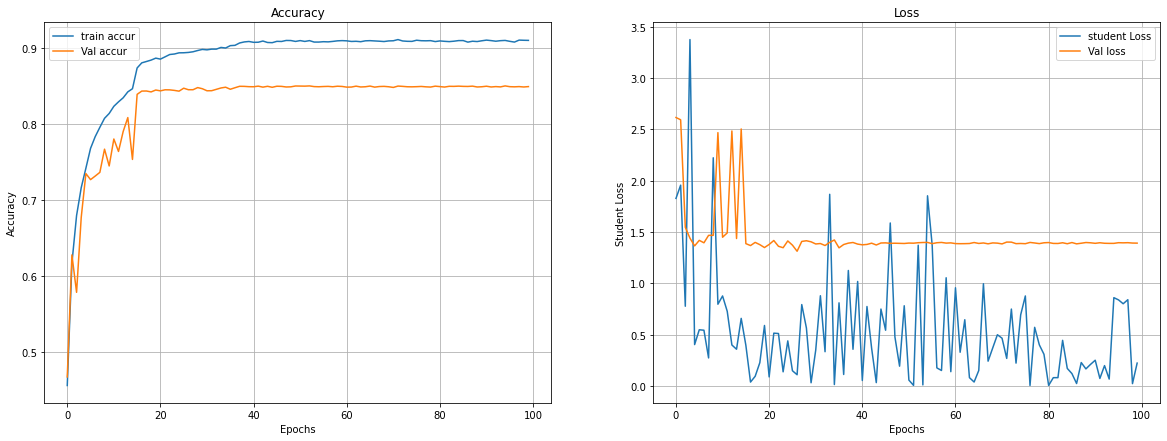

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_10/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 84s 50ms/step - sparse_categorical_accuracy: 0.4414 - student_loss: 1.6585 - Dist_loss: 0.3092 - loss: 0.4441 - val_sparse_categorical_accuracy: 0.4663 - val_student_loss: 2.4777 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.5927 - student_loss: 1.3474 - Dist_loss: 0.2348 - loss: 0.3460 - val_sparse_categorical_accuracy: 0.5404 - val_student_loss: 2.6710 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6475 - student_loss: 1.2121 - Dist_loss: 0.2037 - loss: 0.3046 - val_sparse_categorical_accuracy: 0.5715 - val_student_loss: 1.5777 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6844 - studen

1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8871 - student_loss: 0.4117 - Dist_loss: 0.0743 - loss: 0.1080 - val_sparse_categorical_accuracy: 0.7891 - val_student_loss: 1.3824 - lr: 0.1000
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8894 - student_loss: 0.4055 - Dist_loss: 0.0735 - loss: 0.1067 - val_sparse_categorical_accuracy: 0.8201 - val_student_loss: 1.4756 - lr: 0.1000
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8931 - student_loss: 0.3920 - Dist_loss: 0.0726 - loss: 0.1045 - val_sparse_categorical_accuracy: 0.8160 - val_student_loss: 1.4237 - lr: 0.1000
Epoch 35/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8940 - student_loss: 0.3833 - Dist_loss: 0.0718 - loss: 0.1030
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1562/1562 [==============

Epoch 62/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9379 - student_loss: 0.1980 - Dist_loss: 0.0599 - loss: 0.0737 - val_sparse_categorical_accuracy: 0.8537 - val_student_loss: 1.3822 - lr: 1.0000e-04
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9388 - student_loss: 0.1972 - Dist_loss: 0.0600 - loss: 0.0738 - val_sparse_categorical_accuracy: 0.8529 - val_student_loss: 1.3808 - lr: 1.0000e-04
Epoch 64/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9382 - student_loss: 0.1950 - Dist_loss: 0.0599 - loss: 0.0734 - val_sparse_categorical_accuracy: 0.8533 - val_student_loss: 1.3875 - lr: 1.0000e-04
Epoch 65/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9372 - student_loss: 0.1975 - Dist_loss: 0.0599 - loss: 0.0737
Epoch 65: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9395 - student_loss: 0.1900 - Dist_loss: 0.0598 - loss: 0.0728 - val_sparse_categorical_accuracy: 0.8537 - val_student_loss: 1.3840 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9373 - student_loss: 0.1945 - Dist_loss: 0.0598 - loss: 0.0732 - val_sparse_categorical_accuracy: 0.8529 - val_student_loss: 1.3882 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9379 - student_loss: 0.1975 - Dist_loss: 0.0599 - loss: 0.0737 - val_sparse_categorical_accuracy: 0.8539 - val_student_loss: 1.3812 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9371 - student_loss: 0.1980 - Dist_loss: 0.0599 - loss: 0.0737 - val_sparse_categorical_accuracy: 0.8531 - val_student_loss: 1.3832 - lr: 1.0000e-

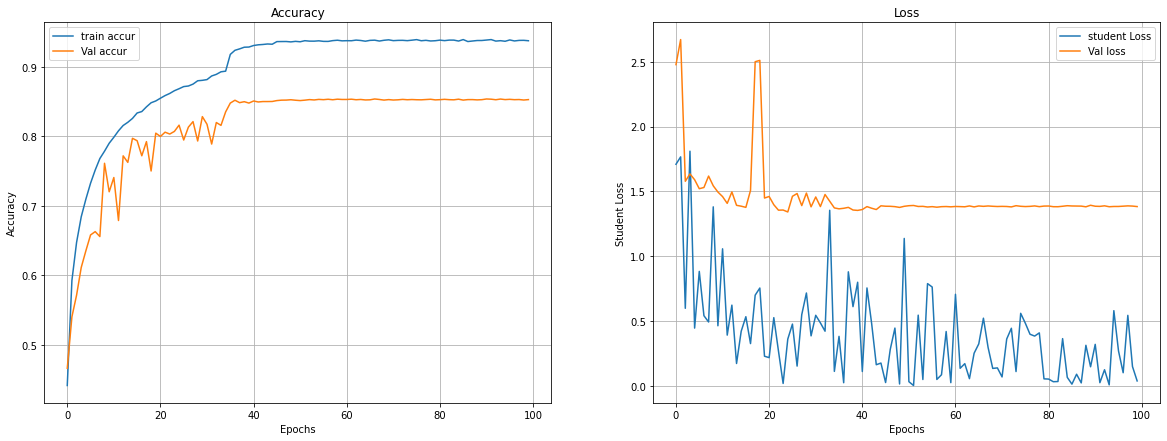

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_15/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 82s 50ms/step - sparse_categorical_accuracy: 0.4294 - student_loss: 1.5922 - Dist_loss: 0.1802 - loss: 0.3214 - val_sparse_categorical_accuracy: 0.4299 - val_student_loss: 1.4788 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.5737 - student_loss: 1.2652 - Dist_loss: 0.1444 - loss: 0.2565 - val_sparse_categorical_accuracy: 0.4974 - val_student_loss: 3.6778 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6349 - student_loss: 1.1205 - Dist_loss: 0.1275 - loss: 0.2268 - val_sparse_categorical_accuracy: 0.5185 - val_student_loss: 1.6223 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6715 - studen

Epoch 31/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8807 - student_loss: 0.3843 - Dist_loss: 0.0544 - loss: 0.0873 - val_sparse_categorical_accuracy: 0.8284 - val_student_loss: 1.4457 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8803 - student_loss: 0.3784 - Dist_loss: 0.0542 - loss: 0.0866 - val_sparse_categorical_accuracy: 0.8281 - val_student_loss: 1.4380 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8827 - student_loss: 0.3806 - Dist_loss: 0.0542 - loss: 0.0869 - val_sparse_categorical_accuracy: 0.8287 - val_student_loss: 1.4347 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8819 - student_loss: 0.3776 - Dist_loss: 0.0540 - loss: 0.0864 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4401 -

Epoch 61/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8824 - student_loss: 0.3747 - Dist_loss: 0.0537 - loss: 0.0858 - val_sparse_categorical_accuracy: 0.8296 - val_student_loss: 1.4359 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8829 - student_loss: 0.3777 - Dist_loss: 0.0539 - loss: 0.0862 - val_sparse_categorical_accuracy: 0.8288 - val_student_loss: 1.4407 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3780 - Dist_loss: 0.0537 - loss: 0.0862 - val_sparse_categorical_accuracy: 0.8290 - val_student_loss: 1.4370 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8820 - student_loss: 0.3789 - Dist_loss: 0.0538 - loss: 0.0863 - val_sparse_categorical_accuracy: 0.8281 - val_student_loss: 1.4339 -

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8828 - student_loss: 0.3749 - Dist_loss: 0.0537 - loss: 0.0859 - val_sparse_categorical_accuracy: 0.8293 - val_student_loss: 1.4358 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8840 - student_loss: 0.3704 - Dist_loss: 0.0538 - loss: 0.0855 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4396 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8830 - student_loss: 0.3760 - Dist_loss: 0.0538 - loss: 0.0860 - val_sparse_categorical_accuracy: 0.8295 - val_student_loss: 1.4378 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8837 - student_loss: 0.3778 - Dist_loss: 0.0538 - loss: 0.0862 - val_sparse_categorical_accuracy: 0.8294 - val_student_loss: 1.4341 - lr: 1.0000e-

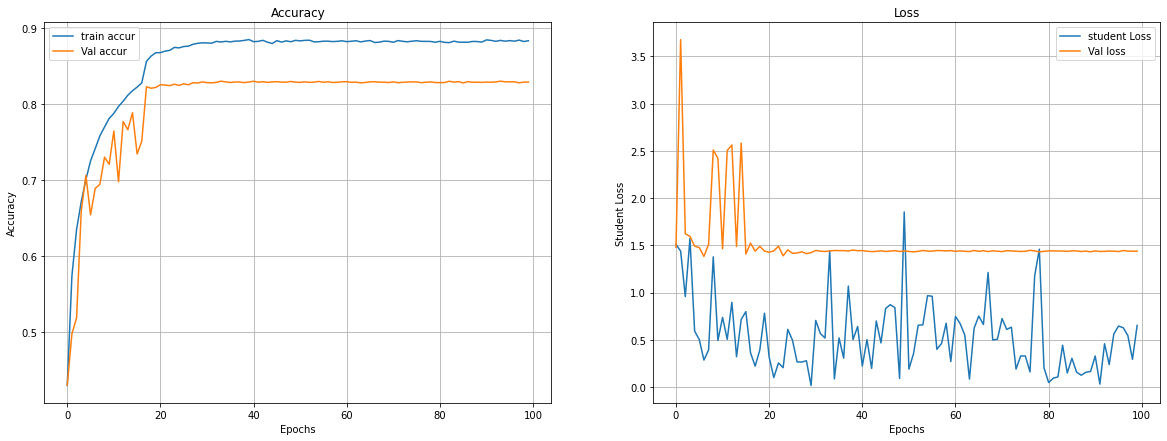

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_20/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 48ms/step - sparse_categorical_accuracy: 0.4377 - student_loss: 1.5400 - Dist_loss: 0.1131 - loss: 0.2558 - val_sparse_categorical_accuracy: 0.4202 - val_student_loss: 2.5368 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.5833 - student_loss: 1.1894 - Dist_loss: 0.0932 - loss: 0.2029 - val_sparse_categorical_accuracy: 0.5317 - val_student_loss: 3.7071 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6428 - student_loss: 1.0491 - Dist_loss: 0.0830 - loss: 0.1796 - val_sparse_categorical_accuracy: 0.5613 - val_student_loss: 2.5676 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6772 - studen

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8725 - student_loss: 0.3954 - Dist_loss: 0.0376 - loss: 0.0734 - val_sparse_categorical_accuracy: 0.8033 - val_student_loss: 1.4269 - lr: 0.1000
Epoch 33/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8767 - student_loss: 0.3803 - Dist_loss: 0.0372 - loss: 0.0715 - val_sparse_categorical_accuracy: 0.7746 - val_student_loss: 1.5040 - lr: 0.1000
Epoch 34/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8793 - student_loss: 0.3730 - Dist_loss: 0.0365 - loss: 0.0702
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8792 - student_loss: 0.3745 - Dist_loss: 0.0366 - loss: 0.0704 - val_sparse_categorical_accuracy: 0.7942 - val_student_loss: 1.4536 - lr: 0.1000
Epoch 35/100
1562/1562 [==============

Epoch 62/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9307 - student_loss: 0.2024 - Dist_loss: 0.0308 - loss: 0.0479 - val_sparse_categorical_accuracy: 0.8365 - val_student_loss: 1.4470 - lr: 1.0000e-04
Epoch 63/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9288 - student_loss: 0.2065 - Dist_loss: 0.0308 - loss: 0.0483 - val_sparse_categorical_accuracy: 0.8365 - val_student_loss: 1.4396 - lr: 1.0000e-04
Epoch 64/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9300 - student_loss: 0.2048 - Dist_loss: 0.0308 - loss: 0.0482 - val_sparse_categorical_accuracy: 0.8368 - val_student_loss: 1.4447 - lr: 1.0000e-04
Epoch 65/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9297 - student_loss: 0.2059 - Dist_loss: 0.0307 - loss: 0.0482
Epoch 65: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9291 - student_loss: 0.2033 - Dist_loss: 0.0308 - loss: 0.0480 - val_sparse_categorical_accuracy: 0.8354 - val_student_loss: 1.4422 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9315 - student_loss: 0.2037 - Dist_loss: 0.0308 - loss: 0.0480 - val_sparse_categorical_accuracy: 0.8358 - val_student_loss: 1.4379 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9305 - student_loss: 0.2067 - Dist_loss: 0.0308 - loss: 0.0484 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4419 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9310 - student_loss: 0.2018 - Dist_loss: 0.0308 - loss: 0.0479 - val_sparse_categorical_accuracy: 0.8364 - val_student_loss: 1.4451 - lr: 1.0000e-

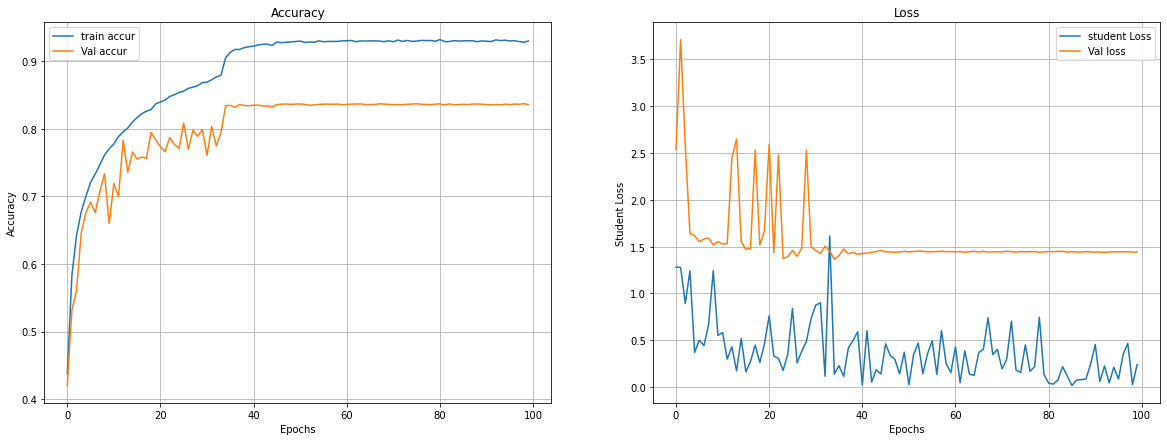

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_25/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 83s 50ms/step - sparse_categorical_accuracy: 0.4478 - student_loss: 1.4974 - Dist_loss: 0.0754 - loss: 0.2176 - val_sparse_categorical_accuracy: 0.4825 - val_student_loss: 1.4410 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.5873 - student_loss: 1.1618 - Dist_loss: 0.0640 - loss: 0.1738 - val_sparse_categorical_accuracy: 0.4802 - val_student_loss: 3.5410 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6384 - student_loss: 1.0296 - Dist_loss: 0.0582 - loss: 0.1553 - val_sparse_categorical_accuracy: 0.6347 - val_student_loss: 1.4114 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6735 - studen

Epoch 32/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8753 - student_loss: 0.3649 - Dist_loss: 0.0295 - loss: 0.0631 - val_sparse_categorical_accuracy: 0.8233 - val_student_loss: 1.3448 - lr: 0.0100
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8759 - student_loss: 0.3639 - Dist_loss: 0.0294 - loss: 0.0628 - val_sparse_categorical_accuracy: 0.8210 - val_student_loss: 1.3417 - lr: 0.0100
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8758 - student_loss: 0.3625 - Dist_loss: 0.0292 - loss: 0.0626 - val_sparse_categorical_accuracy: 0.8215 - val_student_loss: 1.3374 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8775 - student_loss: 0.3552 - Dist_loss: 0.0290 - loss: 0.0617 - val_sparse_categorical_accuracy: 0.8180 - val_student_loss: 1.3312 - lr: 0.0100


Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8869 - student_loss: 0.3280 - Dist_loss: 0.0283 - loss: 0.0583 - val_sparse_categorical_accuracy: 0.8239 - val_student_loss: 1.3575 - lr: 1.0000e-05
Epoch 63/100
1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.8878 - student_loss: 0.3253 - Dist_loss: 0.0283 - loss: 0.0580 - val_sparse_categorical_accuracy: 0.8235 - val_student_loss: 1.3565 - lr: 1.0000e-05
Epoch 64/100
1562/1562 [==============================] - 79s 51ms/step - sparse_categorical_accuracy: 0.8861 - student_loss: 0.3253 - Dist_loss: 0.0283 - loss: 0.0580 - val_sparse_categorical_accuracy: 0.8239 - val_student_loss: 1.3531 - lr: 1.0000e-05
Epoch 65/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8854 - student_loss: 0.3307 - Dist_loss: 0.0283 - loss: 0.0586 - val_sparse_categorical_accuracy: 0.8241 - val_student_loss: 1.3524 -

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8878 - student_loss: 0.3258 - Dist_loss: 0.0282 - loss: 0.0580 - val_sparse_categorical_accuracy: 0.8230 - val_student_loss: 1.3519 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 80s 51ms/step - sparse_categorical_accuracy: 0.8876 - student_loss: 0.3261 - Dist_loss: 0.0283 - loss: 0.0580 - val_sparse_categorical_accuracy: 0.8235 - val_student_loss: 1.3609 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8873 - student_loss: 0.3258 - Dist_loss: 0.0283 - loss: 0.0580 - val_sparse_categorical_accuracy: 0.8231 - val_student_loss: 1.3546 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.8880 - student_loss: 0.3244 - Dist_loss: 0.0283 - loss: 0.0579 - val_sparse_categorical_accuracy: 0.8242 - val_student_loss: 1.3555 - lr: 1.0000e-

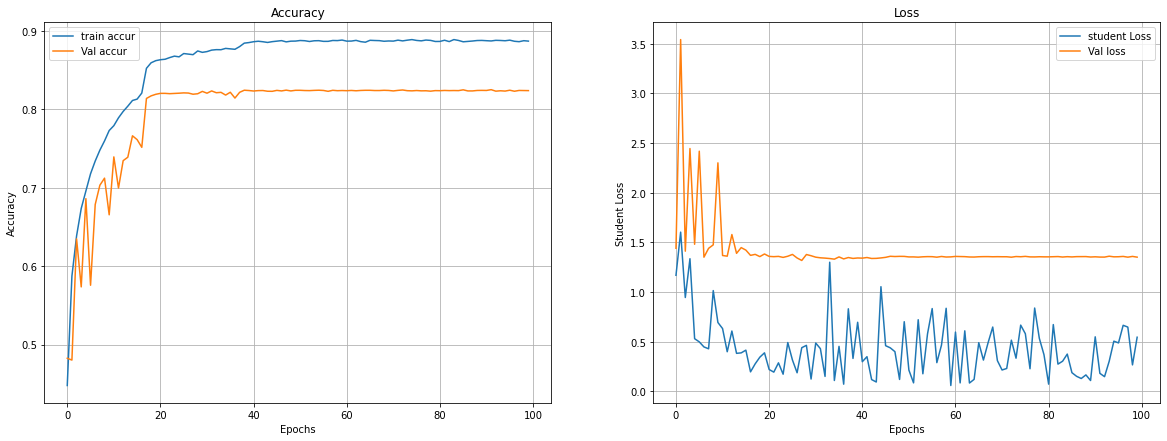

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_30/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 82s 51ms/step - sparse_categorical_accuracy: 0.4470 - student_loss: 1.4990 - Dist_loss: 0.0541 - loss: 0.1986 - val_sparse_categorical_accuracy: 0.4410 - val_student_loss: 3.5388 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.5931 - student_loss: 1.1357 - Dist_loss: 0.0465 - loss: 0.1554 - val_sparse_categorical_accuracy: 0.4859 - val_student_loss: 2.7310 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6486 - student_loss: 0.9985 - Dist_loss: 0.0424 - loss: 0.1380 - val_sparse_categorical_accuracy: 0.4281 - val_student_loss: 2.4818 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6837 - studen

1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8917 - student_loss: 0.3149 - Dist_loss: 0.0207 - loss: 0.0501 - val_sparse_categorical_accuracy: 0.8310 - val_student_loss: 1.4690 - lr: 0.0100
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8962 - student_loss: 0.2995 - Dist_loss: 0.0206 - loss: 0.0485 - val_sparse_categorical_accuracy: 0.8342 - val_student_loss: 1.4881 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.8955 - student_loss: 0.3003 - Dist_loss: 0.0206 - loss: 0.0486 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 1.4792 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8964 - student_loss: 0.2981 - Dist_loss: 0.0205 - loss: 0.0483 - val_sparse_categorical_accuracy: 0.8336 - val_student_loss: 1.4808 - lr: 1.0000e-03
E

1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8992 - student_loss: 0.2930 - Dist_loss: 0.0203 - loss: 0.0476
Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 79s 51ms/step - sparse_categorical_accuracy: 0.8992 - student_loss: 0.2931 - Dist_loss: 0.0203 - loss: 0.0476 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 1.4781 - lr: 1.0000e-05
Epoch 62/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8993 - student_loss: 0.2935 - Dist_loss: 0.0204 - loss: 0.0477 - val_sparse_categorical_accuracy: 0.8339 - val_student_loss: 1.4787 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8994 - student_loss: 0.2938 - Dist_loss: 0.0204 - loss: 0.0477 - val_sparse_categorical_accuracy: 0.8335 - val_student_loss: 1.4752 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [=================

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8990 - student_loss: 0.2940 - Dist_loss: 0.0203 - loss: 0.0477 - val_sparse_categorical_accuracy: 0.8346 - val_student_loss: 1.4732 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8987 - student_loss: 0.2912 - Dist_loss: 0.0203 - loss: 0.0474 - val_sparse_categorical_accuracy: 0.8339 - val_student_loss: 1.4742 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9009 - student_loss: 0.2904 - Dist_loss: 0.0203 - loss: 0.0473 - val_sparse_categorical_accuracy: 0.8335 - val_student_loss: 1.4769 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9005 - student_loss: 0.2900 - Dist_loss: 0.0203 - loss: 0.0473 - val_sparse_categorical_accuracy: 0.8342 - val_student_loss: 1.4817 - lr: 1.0000e-

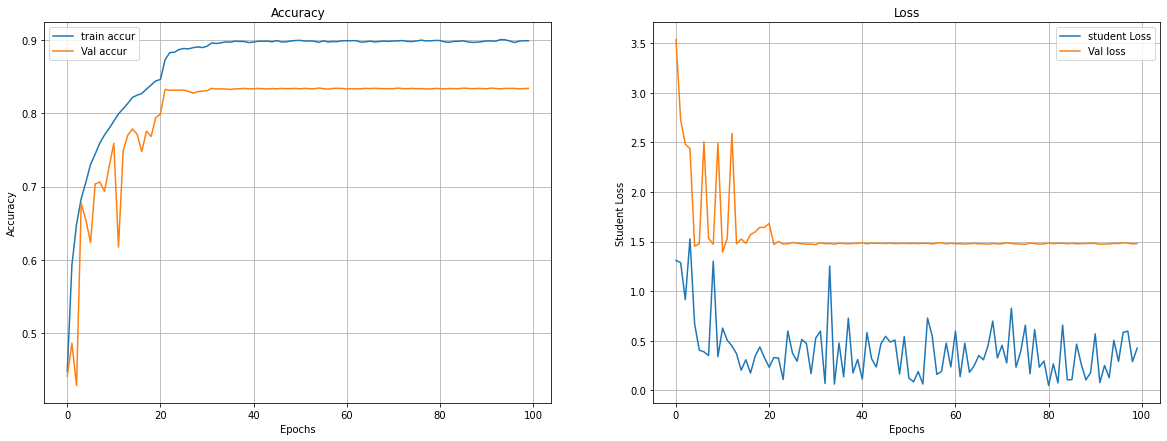

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_35/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 81s 50ms/step - sparse_categorical_accuracy: 0.4433 - student_loss: 1.5050 - Dist_loss: 0.0404 - loss: 0.1868 - val_sparse_categorical_accuracy: 0.4319 - val_student_loss: 2.3811 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.5870 - student_loss: 1.1441 - Dist_loss: 0.0354 - loss: 0.1463 - val_sparse_categorical_accuracy: 0.5834 - val_student_loss: 2.5389 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6442 - student_loss: 0.9978 - Dist_loss: 0.0325 - loss: 0.1291 - val_sparse_categorical_accuracy: 0.5818 - val_student_loss: 1.4358 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.6796 - studen

Epoch 31/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8767 - student_loss: 0.3565 - Dist_loss: 0.0179 - loss: 0.0517 - val_sparse_categorical_accuracy: 0.8250 - val_student_loss: 1.4625 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8761 - student_loss: 0.3573 - Dist_loss: 0.0179 - loss: 0.0518 - val_sparse_categorical_accuracy: 0.8259 - val_student_loss: 1.4581 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8771 - student_loss: 0.3549 - Dist_loss: 0.0179 - loss: 0.0516 - val_sparse_categorical_accuracy: 0.8255 - val_student_loss: 1.4552 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8789 - student_loss: 0.3526 - Dist_loss: 0.0178 - loss: 0.0513 - val_sparse_categorical_accuracy: 0.8254 - val_student_loss: 1.4539 -

Epoch 61/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8764 - student_loss: 0.3548 - Dist_loss: 0.0177 - loss: 0.0515 - val_sparse_categorical_accuracy: 0.8247 - val_student_loss: 1.4593 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8767 - student_loss: 0.3532 - Dist_loss: 0.0178 - loss: 0.0513 - val_sparse_categorical_accuracy: 0.8250 - val_student_loss: 1.4625 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.8789 - student_loss: 0.3513 - Dist_loss: 0.0177 - loss: 0.0511 - val_sparse_categorical_accuracy: 0.8252 - val_student_loss: 1.4571 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8777 - student_loss: 0.3521 - Dist_loss: 0.0178 - loss: 0.0512 - val_sparse_categorical_accuracy: 0.8254 - val_student_loss: 1.4566 -

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8776 - student_loss: 0.3518 - Dist_loss: 0.0178 - loss: 0.0512 - val_sparse_categorical_accuracy: 0.8244 - val_student_loss: 1.4523 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8795 - student_loss: 0.3514 - Dist_loss: 0.0177 - loss: 0.0511 - val_sparse_categorical_accuracy: 0.8250 - val_student_loss: 1.4632 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8789 - student_loss: 0.3506 - Dist_loss: 0.0177 - loss: 0.0510 - val_sparse_categorical_accuracy: 0.8259 - val_student_loss: 1.4687 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8770 - student_loss: 0.3532 - Dist_loss: 0.0177 - loss: 0.0513 - val_sparse_categorical_accuracy: 0.8248 - val_student_loss: 1.4625 - lr: 1.0000e-

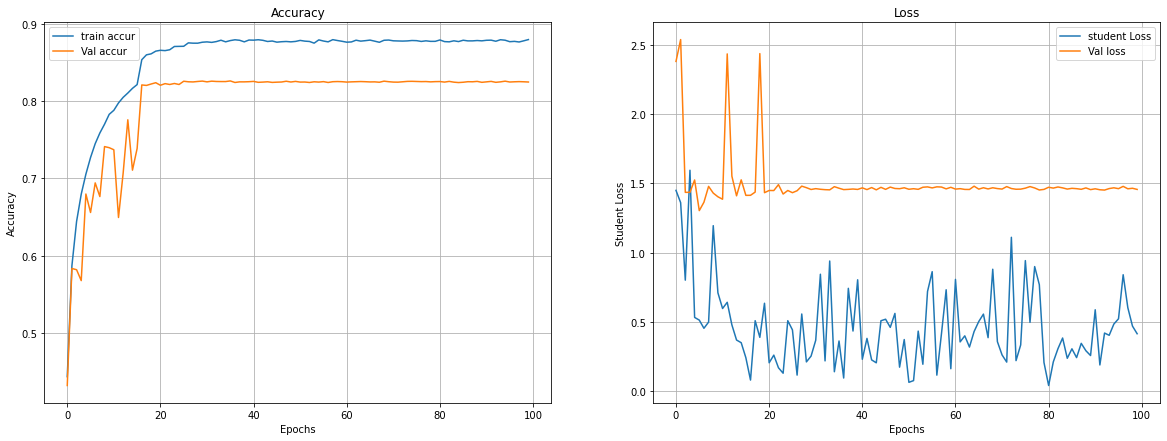

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_40/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 86s 51ms/step - sparse_categorical_accuracy: 0.4498 - student_loss: 1.4977 - Dist_loss: 0.0056 - loss: 0.1548 - val_sparse_categorical_accuracy: 0.3733 - val_student_loss: 2.6064 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.5896 - student_loss: 1.1424 - Dist_loss: 0.0050 - loss: 0.1188 - val_sparse_categorical_accuracy: 0.5933 - val_student_loss: 2.5454 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6484 - student_loss: 0.9835 - Dist_loss: 0.0047 - loss: 0.1026 - val_sparse_categorical_accuracy: 0.6041 - val_student_loss: 1.4594 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6864 - studen

Epoch 31/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8752 - student_loss: 0.3616 - Dist_loss: 0.0032 - loss: 0.0390 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4649 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8783 - student_loss: 0.3560 - Dist_loss: 0.0032 - loss: 0.0384 - val_sparse_categorical_accuracy: 0.8302 - val_student_loss: 1.4654 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8767 - student_loss: 0.3619 - Dist_loss: 0.0032 - loss: 0.0390 - val_sparse_categorical_accuracy: 0.8307 - val_student_loss: 1.4666 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8778 - student_loss: 0.3567 - Dist_loss: 0.0032 - loss: 0.0385 - val_sparse_categorical_accuracy: 0.8295 - val_student_loss: 1.4771 -

Epoch 61/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.8778 - student_loss: 0.3565 - Dist_loss: 0.0031 - loss: 0.0385 - val_sparse_categorical_accuracy: 0.8299 - val_student_loss: 1.4693 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8775 - student_loss: 0.3549 - Dist_loss: 0.0032 - loss: 0.0383 - val_sparse_categorical_accuracy: 0.8304 - val_student_loss: 1.4753 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8783 - student_loss: 0.3529 - Dist_loss: 0.0031 - loss: 0.0381 - val_sparse_categorical_accuracy: 0.8302 - val_student_loss: 1.4730 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.8793 - student_loss: 0.3558 - Dist_loss: 0.0031 - loss: 0.0384 - val_sparse_categorical_accuracy: 0.8302 - val_student_loss: 1.4704 -

1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.8779 - student_loss: 0.3553 - Dist_loss: 0.0032 - loss: 0.0384 - val_sparse_categorical_accuracy: 0.8307 - val_student_loss: 1.4690 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.8787 - student_loss: 0.3534 - Dist_loss: 0.0031 - loss: 0.0382 - val_sparse_categorical_accuracy: 0.8301 - val_student_loss: 1.4745 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.8787 - student_loss: 0.3545 - Dist_loss: 0.0031 - loss: 0.0383 - val_sparse_categorical_accuracy: 0.8300 - val_student_loss: 1.4694 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.8782 - student_loss: 0.3537 - Dist_loss: 0.0031 - loss: 0.0382 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4768 - lr: 1.0000e-

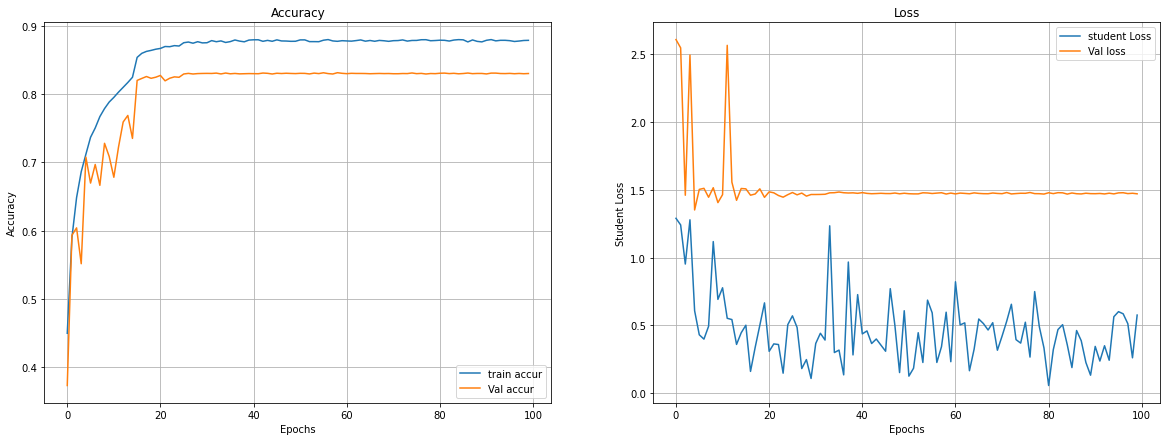

Saving model 
INFO:tensorflow:Assets written to: Resnet8_kd_alpha_0.1_temp_100/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [24]:
for t in T:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_0.1_temp_{t}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs3/{NAME}", histogram_freq = 1)
    
    # Création du resnet 8
    student_test = tf.keras.models.clone_model(student)

    # Création de l'objet Distiller
    dist = Distiller(teacher, student_test)
    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = 0.1,
        temperature = t)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_kd_alpha_0.1_temp_{t}.png")


    print("Saving model ")
    student_test.save(f"Resnet8_kd_alpha_0.1_temp_{t}")
    print("Saving Done !")

    print("Saving Weights ")
    student_test.save_weights(f"w_resnet8_alpha_0.1_temp{t}.h5")
    print("Saving Done !")
    print("")

    print("End !")